# Experimental Results 2: Building Distribution B

After running some initial experiments on a single environment, let us consider multiple buildings at the same time.

<div class="alert alert-info">

Note

In this notebook Gym v0.21 is used, because this version is required for Stable Baselines3 (SB3), an RL algorithm library used here. Thus, the environment API is different compared to other pages in the Bauwerk docs.

</div>

## Evaluation

As in previous experiments we consider the *performance relative to random and optimal control*,

$p' = \frac{p_m-p_r}{p_o-p_r}$,

where $p_m$ is the average reward of the method to be evaluated, $p_r$ and $p_o$ the average rewards of random and optimal control respectively. 

<div class="alert alert-info">

Note

With the performance measure $p'$, a value $>0$ means that the method is better than random, a value close to $1$ means that the method is close to optimal, a value $<0$ means that the method is worse than random, i.e. completely useless.

</div>



## Setting up distribution

To start off we import all relevant packages and sample tasks from Bauwerk's building distribution B. This is the first non-trivial building distribution. It is defined as uniform distribution over battery sizes between 5 and 15 kWh. Otherwise the simulated buildings are identical.

In [1]:
# Setup and helper code
import bauwerk
import bauwerk.evaluation
import bauwerk.benchmarks
import gym
import numpy as np

# The length of each task, i.e. how long we aim to 
TASK_LEN = 24*30 # evaluate on 1 month of actions

# Create SolarBatteryHouse environment
build_dist_b = bauwerk.benchmarks.BuildDistB(seed=0, task_ep_len=TASK_LEN)
print(f"Sampled {len(build_dist_b.train_tasks)} training and"
    f" {len(build_dist_b.test_tasks)} test tasks from building distribution B.")

Sampled 20 training and 10 test tasks from building distribution B.


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Baselines

### Random, optimal & *nocharge* performance

To get started, we compute the performance of taking random, optimal and no charging actions in
each environment. We can see that, with random actions, a larger battery size leads to worse performance as the battery size allows for more (expensive) charging from the grid. On the other hand, for optimal actions, increasing battery size leads to increasing performance as it provides additional flexibility. This effect plateaus eventually as larger battery sizes and additional flexibility can no longer be used within the system. As expected, when not taking any charging actions there is no effect of battery size on performance. Note that here we only consider *operational performance* but ignore other costs such as acquiring and installing a larger battery.

In [2]:
# Get data on different training tasks
env = build_dist_b.make_env()
batt_sizes = []
perf_opts = []
perf_rands = []
perf_nocharges = []
for i, task in enumerate(build_dist_b.train_tasks):
    env = build_dist_b.make_env()
    env.set_task(task)
    perf_opt = bauwerk.evaluation.get_optimal_perf(env, eval_len=TASK_LEN)
    perf_rand, perf_rand_std = bauwerk.evaluation.get_avg_rndm_perf(
        env, 
        eval_len=TASK_LEN,
        num_samples=10,
    )
    perf_nocharge = bauwerk.evaluation.evaluate_actions(np.zeros((TASK_LEN,1)), env)
    batt_sizes.append(env.cfg.battery_size)
    perf_opts.append(perf_opt)
    perf_rands.append(perf_rand)
    perf_nocharges.append(perf_nocharge)

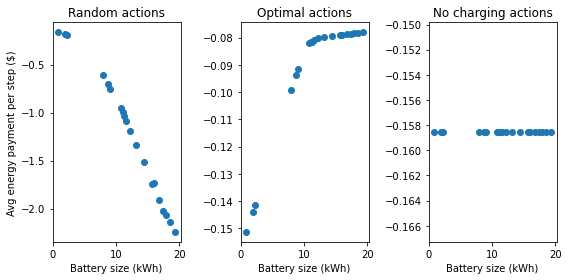

In [3]:
# Plot the effect of battery size in training task performance
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1, 3, 2)
plt.scatter(batt_sizes, perf_opts)
plt.xlabel("Battery size (kWh)")
plt.title("Optimal actions")
plt.subplot(1, 3, 1)
plt.title("Random actions")
plt.ylabel("Avg energy payment per step ($)")
plt.scatter(batt_sizes, perf_rands)
plt.xlabel("Battery size (kWh)")
plt.subplot(1, 3, 3)
plt.title("No charging actions")
plt.scatter(batt_sizes, perf_nocharges)
plt.xlabel("Battery size (kWh)")
plt.tight_layout()

## Conventional reinforcement leanring agents

To start off, we consider the performance of a specialist agent trained on one task, and then applied to another task. As before, we use [Stable Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) to access RL algorithm implementations.

In [4]:
# Helper functions for evaluating methods

from stable_baselines3.common.callbacks import BaseCallback

def eval_model(model, env):
    # Obtaining model actions and evaluating them
    model_actions = []
    obs = env.reset()
    for i in range(TASK_LEN):
        action, _states = model.predict(obs)
        model_actions.append(action)
        obs, _, _, _ = env.step(action)

    p_model = bauwerk.evaluation.evaluate_actions(model_actions[:TASK_LEN], env)
    return p_model

# callback for evaluating callback during training
class EvalCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq = 24*7, verbose=0):
        super().__init__(verbose)
        self.data = []
        self.eval_freq = eval_freq
        self.eval_env = eval_env

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.data.append(eval_model(self.model, self.eval_env))

    def _on_step(self) -> bool:
        if self.num_timesteps % self.eval_freq == 0:
            self.data.append(eval_model(self.model, self.eval_env))

        return True

# Measuring performance relative to random and optimal
def compute_rel_perf(p_model, p_rand, p_opt):
    return (p_model - p_rand)/(p_opt - p_rand)

#### SAC

After setting up all helper functions we consider a popular RL algorithm - *Soft Actor-Critic* (SAC).

In [5]:
from stable_baselines3 import SAC

NUM_TRAIN_STEP = 24 * 365 * 2

example_env = build_dist_b.make_env()
example_env.set_task(build_dist_b.train_tasks[0])

print(f"Training on task with battery size {example_env.battery.size}.")

model_sac = SAC(
    policy="MultiInputPolicy",
    env=example_env, 
    verbose=0,
)

eval_env = build_dist_b.make_env()
eval_env.set_task(build_dist_b.test_tasks[0])
eval_callback = EvalCallback(eval_env=eval_env)
print(f"Evaluating on task with battery size {eval_env.battery.size}.")

eval_env_same_as_train = build_dist_b.make_env()
eval_env_same_as_train.set_task(build_dist_b.train_tasks[0])
train_callback = EvalCallback(eval_env=eval_env_same_as_train)

model_sac.learn(total_timesteps=NUM_TRAIN_STEP,callback=[eval_callback,train_callback])

p_model_sac = eval_model(model_sac, example_env)

print(f"Avg reward (per step) with model actions: {p_model_sac:.4f}")

p_rel_sac = compute_rel_perf(p_model_sac, p_rand=perf_rands[0], p_opt=perf_opts[0])
print(f"Performance relative to random and optimal: {p_rel_sac:.4f}")

Training on task with battery size 11.201863326582833.
Evaluating on task with battery size 8.631929091700194.
Avg reward (per step) with model actions: -0.1030
Performance relative to random and optimal: 0.9774


#### Training performance

Next we plot the combined results of the baselines, random and optimal actions, and our RL agent SAC on the evaluation and trainings environments. The random and optimal performance are based on the training environment.

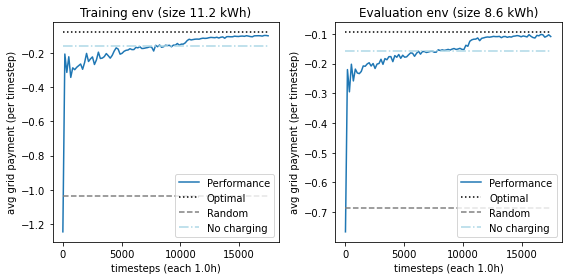

In [6]:
import matplotlib.pyplot as plt

x = np.arange(0,NUM_TRAIN_STEP,eval_callback.eval_freq)
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title(f"Training env (size {example_env.battery.size:.01f} kWh)")
plt.plot(
    x, train_callback.data[:NUM_TRAIN_STEP//train_callback.eval_freq + 1], label="Performance"
)
plt.hlines(perf_opts[0], 0, NUM_TRAIN_STEP, label="Optimal", linestyle=":", color="black")
plt.hlines(perf_rands[0], 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(perf_nocharges[0], 0, NUM_TRAIN_STEP, label="No charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

# second plot
plt.subplot(1, 2, 2)
plt.title(f"Evaluation env (size {eval_env.battery.size:.01f} kWh)")
plt.plot(
    x, eval_callback.data[:NUM_TRAIN_STEP//eval_callback.eval_freq + 1], label="Performance"
)
perf_eval_rand, _ = bauwerk.evaluation.get_avg_rndm_perf(
        eval_env, 
        eval_len=TASK_LEN,
        num_samples=10,
    )
perf_eval_opt = bauwerk.evaluation.get_optimal_perf(eval_env, eval_len=TASK_LEN)
plt.hlines(perf_eval_opt, 0, NUM_TRAIN_STEP, label="Optimal", linestyle=":", color="black")
plt.hlines(perf_eval_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")

plt.hlines(perf_nocharges[0], 0, NUM_TRAIN_STEP, label="No charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")
plt.tight_layout()

## Evaluation of model on full range of battery sizes

In the previous section, we observed that the model is reasonably adaptive to one other battery sizes, but we only tested on one other battery size. In this section, we consider a full range of battery sizes between 1 and 20kWh. We observe that whilst the model performs very well with small battery sizes, it performs very poorly on large battery sizes. Conclusion, there is some generalisation, in particular to smaller battery sizes, but just training on a single environment is not enough to fully solve the distribution.

In [7]:
# evaluating performance of agent across different battery sizes

dist_env = build_dist_b.make_env()

battery_sizes = np.arange(1,21,1)
perf_per_task = []
opt_perf_per_task = []
for size in battery_sizes:
    task = bauwerk.benchmarks.Task(
        cfg=bauwerk.envs.solar_battery_house.EnvConfig(
            battery_size=size, 
            episode_len=TASK_LEN
        )
    )
    dist_env.set_task(task)
    perf_sac = eval_model(model_sac, dist_env)
    perf_opt = bauwerk.evaluation.get_optimal_perf(dist_env, eval_len=TASK_LEN)
    perf_per_task.append(perf_sac)
    opt_perf_per_task.append(perf_opt)

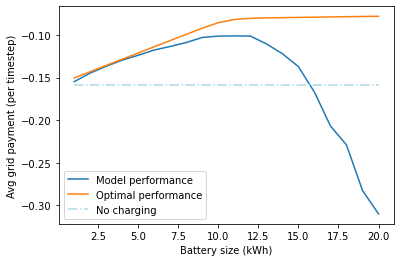

In [8]:
plt.plot(battery_sizes, perf_per_task, label="Model performance")
plt.plot(battery_sizes, opt_perf_per_task, label="Optimal performance")
plt.xlabel("Battery size (kWh)")
plt.ylabel(f"Avg grid payment (per timestep)")
plt.hlines(perf_nocharges[0], 1, len(batt_sizes), label="No charging", linestyle="-.", color="lightblue")
plt.legend()

Further experiments to run
- How does changing the action space affect the cross-task performance?
- Training on all training tasks, and then evaluating on test distribution.


> Note for reproducibility: this entire notebook was executed inside the devcontainer of the Bauwerk repository.